# Exercise 01: Solution

In this exercise we explore how the extracellular potential decays with distance from some simple neuron models.

As described in PCMN [1] Section 13.2, a single-compartment (point) neuron does not generate any extracellular signal:
the simplest neuron model generating an extracellular potential is the two-compartment model where, 
for example, one compartment represents the soma and the other the dendrite. In this exercise we will explore the extracellular potential set up by various simple neuron models. 

For the case of a single static (constant) current source $i$ in an infinite homogeneous and isotropic volume conductor with conductivity $\sigma$, the potential around the position of the current source is given by (PCMN Equation 10.15):

\begin{equation}
V_\mathrm{e}(r)  = \frac{i}{4 \pi \sigma r} .
\label{eq:Ve_single_source}
\end{equation}

In the present exercise we will assume the value $\sigma=0.3$ S/m.

[1] Sterratt, Graham, Gillies, Einevoll, & Willshaw (2023). Principles of Computational Modelling in Neuroscience (2nd ed.) doi:10.1017/9781108672955

## Task 1: Current monopoles

While single-compartment neurons do not produce any extracellular potential, the potential
set up by a thin and sharp electrode injecting a current into the extracellular space
will resemble the potential described by the equation above. 


* Write the Python code to make a 2D plot of the extracellular potential around the electrode tip set up by a constant current sink with a current of -1.0 nA. 
* Make a double-logarithmic plot showing how the potential varies with distance from the neuron, from 10 µm to 5000 µm. Can you read out the characteristic $1/r$-decay with distance from the plot? 



## Solution:

We define some measurement positions, where we would like to calculate the extracellular potential.

Firsly, we make a dense grid of measurement positions around the current sources, to enable us to visually inspect the potential in the vicinity of the current sources.

Secondly, we make a straight line of measurement positions with increasing distance from the current sources, to investigate the decay of the extracellular potential with distance.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.3  # Extracellular conductivity (S/m)

# Create a grid of measurement locations
dx = 10
dz = 10
grid_x, grid_z = np.mgrid[-400:401:dx, -405:400:dz]
grid_y = np.ones(grid_x.shape) * 0
elecs_pos_grid = np.array([grid_x.flatten(), 
                           grid_y.flatten(), 
                           grid_z.flatten()])

# Create a straight line of measurement locations with increasing distance:
num_elecs_lin = 10000
xe_lin = np.zeros(num_elecs_lin)
ye_lin = np.zeros(num_elecs_lin)
ze_lin = -np.linspace(10, 5000, num_elecs_lin)
elecs_pos_lin = np.array([xe_lin, ye_lin, ze_lin])
dist = np.sqrt(xe_lin**2 + ye_lin**2 + ze_lin**2)



Now we define a function to calculate the extracellular potential from a set of current sources. Note that this formula correspond to eq (10.15) in the book PCMN [1].

In [2]:
def calc_extracellular_potential(elecs_pos, sources_pos, imem):
    """
    Function to return the extracellular potential, v_e (in µV), at a given set of 
    measurement positions ('elecs_pos'), resulting from a given set of 
    current source positions ('sources_pos') with corresponding current amplitudes 'imem'.
    """
    num_elecs = len(elecs_pos[0, :])
    num_sources = len(sources_pos[0, :])
    r2 = np.zeros((num_elecs, num_sources))
    for elec in range(num_elecs):
        for s in range(num_sources):
            r2[elec, s] = np.sum([(sources_pos[n, s] - elecs_pos[n, elec])**2
                                 for n in range(3)])


    r2[r2 < 1e-9] = 1e-5  # To avoid division by zero we enforce a tiny minimal distance
    mapping = 1 / (4 * np.pi * sigma * np.sqrt(r2))
    v_e = mapping @ imem * 1000
    return v_e


We now make a function to plot the extracellular potential as a colorplot in the vicinity of the current sources, and also show how the potential decays with distance from the sources: 

In [3]:

def plot_potential_from_current_sources(sources_pos, imem, sim_name):
    """
    Function to plot the calculated extracellular potential. 
    """
    
    v_e = calc_extracellular_potential(elecs_pos_lin, sources_pos, imem)

    v_e_grid = calc_extracellular_potential(elecs_pos_grid, sources_pos, imem).reshape(grid_x.shape)

    # Helpers to make colorplot
    num = 15
    levels = np.logspace(-2.2, 0, num=num)
    scale_max = 10

    levels_norm = scale_max * np.concatenate((-levels[::-1], levels))
    div_cmap = plt.cm.bwr
    colors_from_map = [div_cmap((i/(len(levels_norm) - 2)))
                       for i in range(len(levels_norm) -1)]
    colors_from_map[num - 1] = (1.0, 1.0, 1.0, 1.0)

    plt.close("all")

    fig = plt.figure(figsize=[8, 3])
    fig.subplots_adjust(wspace=0.7, right=0.98, left=0.07, bottom=0.17)

    ax1 = fig.add_subplot(121, aspect=1, xlim=[-400, 400], ylim=[-400, 400],
                       xlabel="x (µm)", ylabel="z (µm)", frameon=False)


    loglog_ylim = [1e-5, 2e0]
    loglog_xlim = [10, 5000]
    ax2 = fig.add_subplot(122, ylim=loglog_ylim, xlim=loglog_xlim, 
                       xlabel="Distance (µm)", 
                          ylabel="|$V_\mathrm{e}$ (normalized)|")
    ax2.grid(True)
    ep_intervals = ax1.contourf(grid_x, grid_z, v_e_grid,
                                   zorder=-2, colors=colors_from_map,
                                   levels=levels_norm,  alpha=1)

    for source_idx, pos_ in enumerate(sources_pos.T):
        if imem[source_idx] > 0:
            clr = 'r'
            marker = '+'
        else:
            clr = 'b'
            marker = '_'

        ax1.plot(pos_[0], pos_[2], 'o', c=clr, mec='k', ms=10)
        ax1.plot(pos_[0], pos_[2], marker=marker, c='w')


    ax1.plot(xe_lin, ze_lin, '--', c='k')

    cax = fig.add_axes([0.4, 0.15, 0.015, 0.7], )
    cbar = fig.colorbar(ep_intervals, cax=cax)
    cbar.set_label('$V_\mathrm{e}$ (µV)', labelpad=0)
    cbar.set_ticks([-10, -1, -0.1, 0.1, 1, 10])

    l1, = ax2.loglog(dist, v_e / v_e[0], label=sim_name, c='k')
        
    # Add slope-markers
    for slope in [1, 2, 3]:
        if v_e[-1] / v_e[0] < loglog_ylim[0]:
            slope_end_y = loglog_ylim[0]
            slope_end_x = dist[np.argmin(np.abs(
                v_e / v_e[0] - loglog_ylim[0]))]
        else:
            slope_end_y = v_e[-1] / v_e[0]
            slope_end_x = loglog_xlim[1]

        slope_start_y = slope_end_y * 5 ** slope
        slope_start_x = slope_end_x / 5

        ax2.plot([slope_start_x, slope_end_x], 
                 [slope_start_y, slope_end_y], c='gray', lw=4, ls=':')
        
        ax2.text(slope_start_x, slope_start_y, '$r^{-%d}$' % slope, 
                 va='top', ha='right', color='gray', fontsize=15)

    ax2.legend(frameon=False)

    fig.savefig(f"exercise_pot_decay_{sim_name}.png")


We first look at a single current source, that is, a monopole.

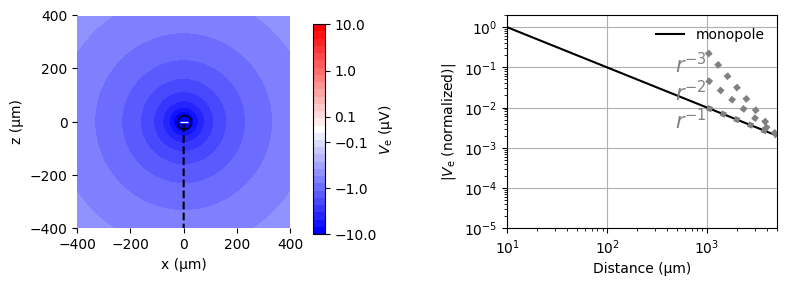

In [4]:
# Current amplitude of sink:
imem = np.array([-1.0])

# Position of source:
xs = np.array([0.0])
ys = np.array([0.0])
zs = np.array([0.0])

sources_pos = np.array([xs, ys, zs])

plot_potential_from_current_sources(sources_pos, imem, "monopole")

Left: 2D color plot of extracellular potential set up by a single current source.

Right: Decay with distance of extracellular potential from the single current source. The potential is normalized to the value of the potential at a distance of 10 µm. The $1/r$ distance decay is seen from the slope of -1.


## Task 2: Two-compartment neuron

Next we consider a two-compartment model with a 100 µm distance between 
the top apical compartment and the bottom soma compartment. There is a constant membrane current sink
of -1.0 nA in the apical compartment. This could mimic the effect of a (really) long-lasting excitatory input to the apical compartment.

* What is the membrane current in the basal compartment?
* What is the axial current between the two compartments?
* Write the Python code to make a 2D plot of the extracellular potential around the two-compartment neuron.
* Make a double-logarithmic plot of how the potential varies with distance from the neuron when moving in the vertical direction, that is, along the line connecting the two compartments, starting from 10 µm below the soma compartment. Can you from the plot read out the characteristic $1/r^2$ dipolar decay expected for large distances? 
* Why doesn't the potential decay as $1/r^2$ close to the neuron?



## Solution:

* From the requirement of current conservation it follows that the membrane current in the soma compartment must have the same magnitude as the current sink in the dendrite compartment (-1.0 nA) and directed outwards (that is, a current source).
* The axial current also has a magnitude of 1.0 nA and is directed from the dendrite compartment to the soma compartment.
* The relevant formula is
\begin{equation}
V_\mathrm{e}(\mathbf{r})  = \frac{-i}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_d|} + \frac{i}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_s|}
\end{equation}
where $\mathbf{r}_d$ and $\mathbf{r}_s$ are the positions of the dendrite and soma compartments, respectively, and $i=1.0$ nA.

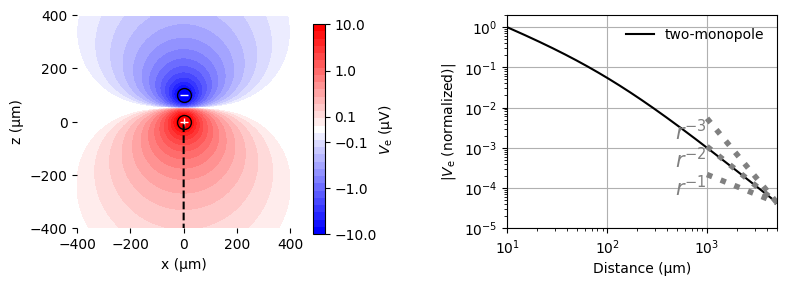

In [5]:
# Current amplitude of sources/sinks:
imem = np.array([1.0, -1.0])

# Position of sources:
xs = np.array([0.0, 0.0])
ys = np.array([0.0, 0.0])
zs = np.array([0.0, 100])

sources_pos = np.array([xs, ys, zs])

plot_potential_from_current_sources(sources_pos, imem, "two-monopole")

Left: 2D color plot of extracellular potential set up by two-monopole model. The dashed line depicts the direction of the curve in the right panel.
Right: Decay with vertical distance of extracellular potential from the model. The potential is normalized to the value of the potential at a distance of 10 µm below the soma compartment. 

* The $1/r^2$ distance decay is seen from the slope of -2 of the curve for distances larger than a a few hundred micrometers.

* The $1/r^2$ distance decay is only expected for distances much larger than the distance between the two monopolar sources (100 µm). Closer to the neuron the decay with distance will be smaller (see PCMN Box 13.3).

## Task 3: Three-compartment neuron
We now consider a three-compartment model with three vertically aligned compartments where the lowest compartment corresponds to the soma, while the middle and top compartments correspond to dendritic compartments. The distance between neighbouring compartments is 50 µm. The middle compartment is a current sink with constant amplitude -1 nA, while the bottom and top compartments are current sources, both with 0.5 nA amplitudes. This could (maybe) mimic the effect of a (really) long-lasting excitatory input to the middle of an apical dendritic compartment.

* Write the Python code to make a 2D plot of the extracellular potential around the three-compartment neuron.
* Make a double-logarithmic plot of how the potential varies with distance from the neuron when moving in the vertical direction, that is, along the line connecting the two compartments? How does the potential decay with distance far away from the neuron? Why?



## Solution:
If we add one more source, we can make a quadrupole:

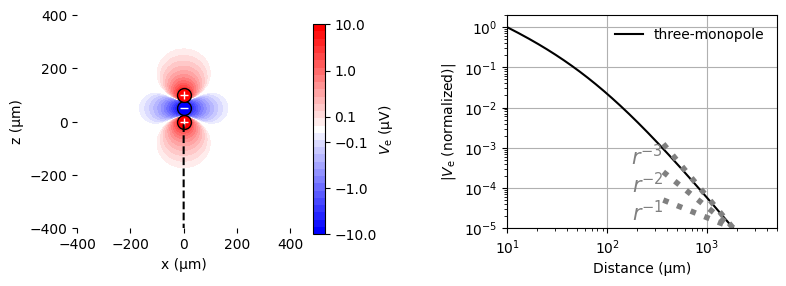

In [6]:
# Current amplitude of sources/sinks:
imem = np.array([0.5, -1, 0.5])

# Position of sources:
xs = np.array([0.0, 0.0, 0.0])
ys = np.array([0.0, 0.0, 0.0])
zs = np.array([0.0, 50, 100])

sources_pos = np.array([xs, ys, zs])

plot_potential_from_current_sources(sources_pos, imem, "three-monopole")

Left: 2D color plot of extracellular potential set up by three-monopole model.
Right: Decay with horisontal distance of extracellular potential from the middle compartment of the model. 
The potential is normalized to the value of the potential at a horisontal distance of 10 µm from the middle compartment.

The relevant formula is
\begin{equation}
V_\mathrm{e}(\mathbf{r})  = \frac{i_t}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_t|} 
+\frac{i_m}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_m|}
+\frac{i_b}{4 \pi \sigma |\mathbf{r}-\mathbf{r}_b|}
\end{equation}
where $\mathbf{r}_t$, $\mathbf{r}_m$, and $\mathbf{r}_b$ are the positions of the top, middel and bottom compartments, respectively. Further, $i_t=0.5$ nA, $i_m=-1.0$ nA, and $i_b=0.5$ nA.

* Double-logarithmic plot is in right panel of the figure. A $1/r^3$ distance decay is seen from the slope of -3 of the curve for distances larger than about hundred micrometers. This reflects that the configuration of current sources/sinks corresponds to a linear current quadrupole (as described in electromagnetism textbooks), while there is no current dipole contribution. The sharper decay of the potential with distance from around a quadrupolar source configuration compared to a dipolar source configurations can also be seen by visual comparison of the figures.
